# IOD_seasonality: Seasonal Variability of SST Anomalies in the Tropical Indian Ocean¶
Computes the ratio of austral winter (Jun-Aug) to spring (Sep-Nov) standard deviation of sea surface temperature anomalies (SSTA) in the Dipole Mode Index (gradient between the western equatorial Indian Ocean (50E-70E and 10S-10N) and the south eastern equatorial Indian Ocean (90E-110E and 10S-0N). This metric evaluates the seasonality of IOD variability.

# Datasets Used for Seasonality Comparison
The following reference datasets are used to evaluate the seasonal variability of IOD-related SST anomalies in model simulations:

TropFlux (1979–2018): The primary dataset for comparison, designed for analysing tropical climate variability, including surface fluxes and SST anomalies.
Additional datasets include:

20CRv2 (1871–2012): A historical reanalysis product providing long-term atmospheric data using surface pressure observations.
ERA-Interim (1979–2018): A high-resolution reanalysis dataset offering consistent atmospheric and surface variable estimates.
ERSSTv5 (1854–2018): A globally gridded dataset optimised for climate monitoring, including ENSO-related SST anomaly studies.
HadISST (1870–2018): A historical dataset combining SST and sea ice observations with reconstructions.
NCEP2 (1979–2018): A second-generation reanalysis product delivering improved atmospheric and surface data globally.

In [5]:
from esmvalcore.dataset import Dataset

In [6]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}
model_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacello', mip='Ofx')

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    tier=2),
# "ERA-Interim": 
#     Dataset(
#     short_name='tos',
#     dataset='ERA-Interim',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

In [7]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/esmvalcore/preprocessor/_io.py:265: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  calendar_index = int(


In [8]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import mask_landsea
import iris

import numpy as np

import matplotlib.pyplot as plt
import iris.quickplot as qplt

In [16]:
def sst_austral(cube, season): #season->'NDJ','MAM'
    iod_east = {"start_longitude": 90., "end_longitude": 110., "start_latitude": -10., "end_latitude": 0.}
    iod_west = {"start_longitude": 50., "end_longitude": 70., "start_latitude": -10., "end_latitude": 10.}
    # cube = regrid(cube, target_grid="1x1", scheme="linear")


    cube = convert_units(cube, units="degC")
    # cube = mask_landsea(cube, mask_out="land")
    cube_west = extract_region(cube, **iod_west)
    cube_east = extract_region(cube, **iod_east)

    # remove seasonal cycle
    cube_west = anomalies(cube_west, period='monthly')
    cube_east = anomalies(cube_east, period='monthly')
    #detrend
    cube_west = area_statistics(cube_west, operator='mean')
    cube_east = area_statistics(cube_east, operator='mean')
    
    cube_west = extract_season(cube_west, season) # get season
    cube_east = extract_season(cube_east, season) # get season

    #dmi = iod_west - iod_east
    cube_dmi = cube_west - cube_east
    # compute temporal standard deviation
    cube = climate_statistics(cube_dmi, operator="std_dev", period="full")
    return cube

def sst_std(cube):
    iod_east = {"start_longitude": 90., "end_longitude": 110., "start_latitude": -10., "end_latitude": 0.}
    iod_west = {"start_longitude": 50., "end_longitude": 70., "start_latitude": -10., "end_latitude": 10.}
    # cube = regrid(cube, target_grid="1x1", scheme="linear")


    cube = convert_units(cube, units="degC")
    # cube = mask_landsea(cube, mask_out="land")
    cube_west = extract_region(cube, **iod_west)
    cube_east = extract_region(cube, **iod_east)

    # remove seasonal cycle
    cube_west = anomalies(cube_west, period='monthly')
    cube_east = anomalies(cube_east, period='monthly')
    #detrend
    cube_west = area_statistics(cube_west, operator='mean')
    cube_east = area_statistics(cube_east, operator='mean')
    
    cube_dmi = cube_west - cube_east
    cube = climate_statistics(cube_dmi, operator="std_dev", period="monthly") #monthly to plot months
    return cube
    
def sst_std_3(cube):
    iod_trop = {"start_longitude": 50., "end_longitude": 110., "start_latitude": -10., "end_latitude": 10.}

    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **iod_trop)
    cube = anomalies(cube,period='monthly')
    cube = meridional_statistics(cube, 'mean')
    cube = climate_statistics(cube, operator="std_dev", period="monthly") #monthly
    return cube

In [17]:
model_datasets_prep = {name: sst_austral(dataset, 'JJA') for name, dataset in model_datasets.items()}
obs_datasets_prep = {name: sst_austral(dataset,'JJA') for name, dataset in obs_datasets.items()}

model_datasets_prep2 = {name: sst_austral(dataset, 'SON') for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: sst_austral(dataset,'SON') for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along second dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along second dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along first dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along first dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2140: IrisVagueMetadataWarning: Collapsin

# Diagnostic Level 1
The first level shows the diagnostic used to compute the metric and highlight the difference between the model and the reference.

In [13]:
model_ = {'australwinter':model_datasets_prep["ACCESS-ESM1-5"], 'australspring':model_datasets_prep2["ACCESS-ESM1-5"]}

obs_ = {'australwinter':obs_datasets_prep["HadISST"], 'australspring':obs_datasets_prep2["HadISST"]}

mod_seas = model_['australwinter'].data.item()/model_['australspring'].data.item()
obs_seas = obs_['australwinter'].data.item()/obs_['australspring'].data.item()

# abs((mod_seas-obs_seas)/obs_seas)*100, mod_seas, obs_seas

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Text(0.75, 0.8, '* observation')

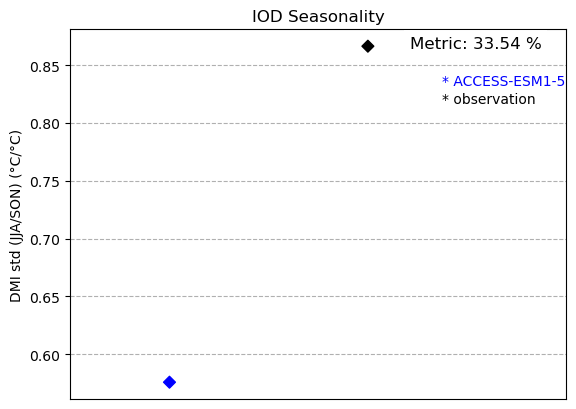

In [14]:
ssta_std = [mod_seas, obs_seas]
plt.scatter(range(len(ssta_std)), ssta_std, c=['blue','black'], marker='D')

plt.xlim(-0.5,2)#range(-1,3,1)) #['model','obs']
plt.xticks([])

plt.ylabel('DMI std (JJA/SON) (°C/°C)')
plt.grid(linestyle='--', axis='y')
plt.title('IOD Seasonality')

metricval = abs((mod_seas-obs_seas)/obs_seas)*100

plt.text(0.95, 0.95, f'Metric: {metricval:.2f} %', fontsize=12, ha='right', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.text(0.75,0.85, '* ACCESS-ESM1-5', color='blue',transform=plt.gca().transAxes)
plt.text(0.75,0.8, '* observation', color='black',transform=plt.gca().transAxes)
# plt.legend(loc='lower right')

Figure 1: Ratio of winter to spring standard deviation of the Dipole Mode Index, illustrating the seasonal timing of SSTA. The model typically exhibits weaker variability than observed, indicating that IOD events ... In this case, the seasonal timing is slightly too ..g. Black markers represent the reference data, while blue markers represent the model output. The derived metric is the absolute relative difference, calculated as: ( \text{abs}((\text{model} - \text{ref}) / \text{ref}) \times 100 ).

# Diagnostic Level 2
The second level shows the mean annual structure of the ENSO amplitude: the 12 months standard deviation of the anomalies.

In [18]:
model_data_prep = {name: sst_std(dataset) for name, dataset in model_datasets.items()}
obs_data_prep = {name: sst_std(dataset) for name, dataset in obs_datasets.items()}

data_prep_2 = [model_data_prep["ACCESS-ESM1-5"], obs_data_prep["HadISST"]]

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along second dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along second dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along first dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along first dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2140: IrisVagueMetadataWarning: Collapsin

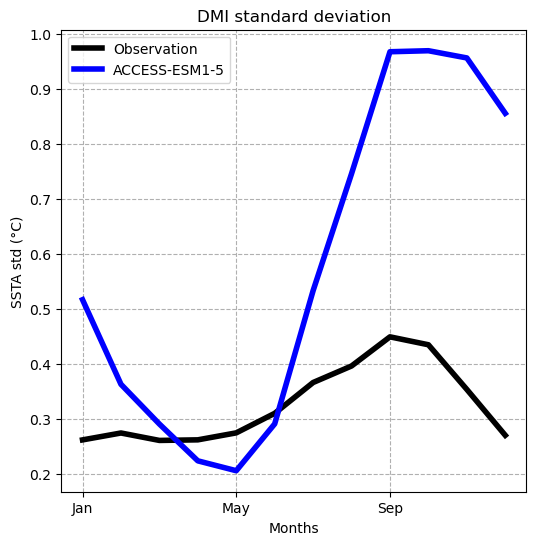

In [19]:

# Create the plot
plt.figure(figsize=(6, 6))

# Plot observation data in black
qplt.plot(data_prep_2[1], color='black', label='Observation', linewidth=4)

# Plot model data in blue
qplt.plot(data_prep_2[0], color='blue', label='ACCESS-ESM1-5', linewidth=4)

# Define x-axis labels
# months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months = ['Jun', 'May', 'Sep']
plt.xticks(range(1,13,4),labels=months)
# Set the x and y axis labels
plt.xlabel('Months')
plt.ylabel('SSTA std (°C)')
plt.title('DMI standard deviation')
plt.grid(linestyle='--'); plt.legend()

Figure 2: Mean annual structure of the standard deviation of the DMI, illustrating the seasonal variability. The model typically shows too .... The black curve represents the reference data, while the blue curve corresponds to the model output.

# Diagnostic Level 3

The third level shows the spatio-mean annual structure of the tropical Indian Ocean amplitude: the Hovmöller of the standard deviation of anomalies in the equatorial Indian Ocean.

In [20]:
model_data_prep3 = {name: sst_std_3(dataset) for name, dataset in model_datasets.items()}
obs_data_prep3 = {name: sst_std_3(dataset) for name, dataset in obs_datasets.items()}

data_prep_3 = {**model_data_prep3, "HadISST":obs_data_prep3["HadISST"]}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:1978: IrisGuessBoundsWarning: Coordinate 'month_number' is not bounded, guessing contiguous bounds.
  warnings.warn(


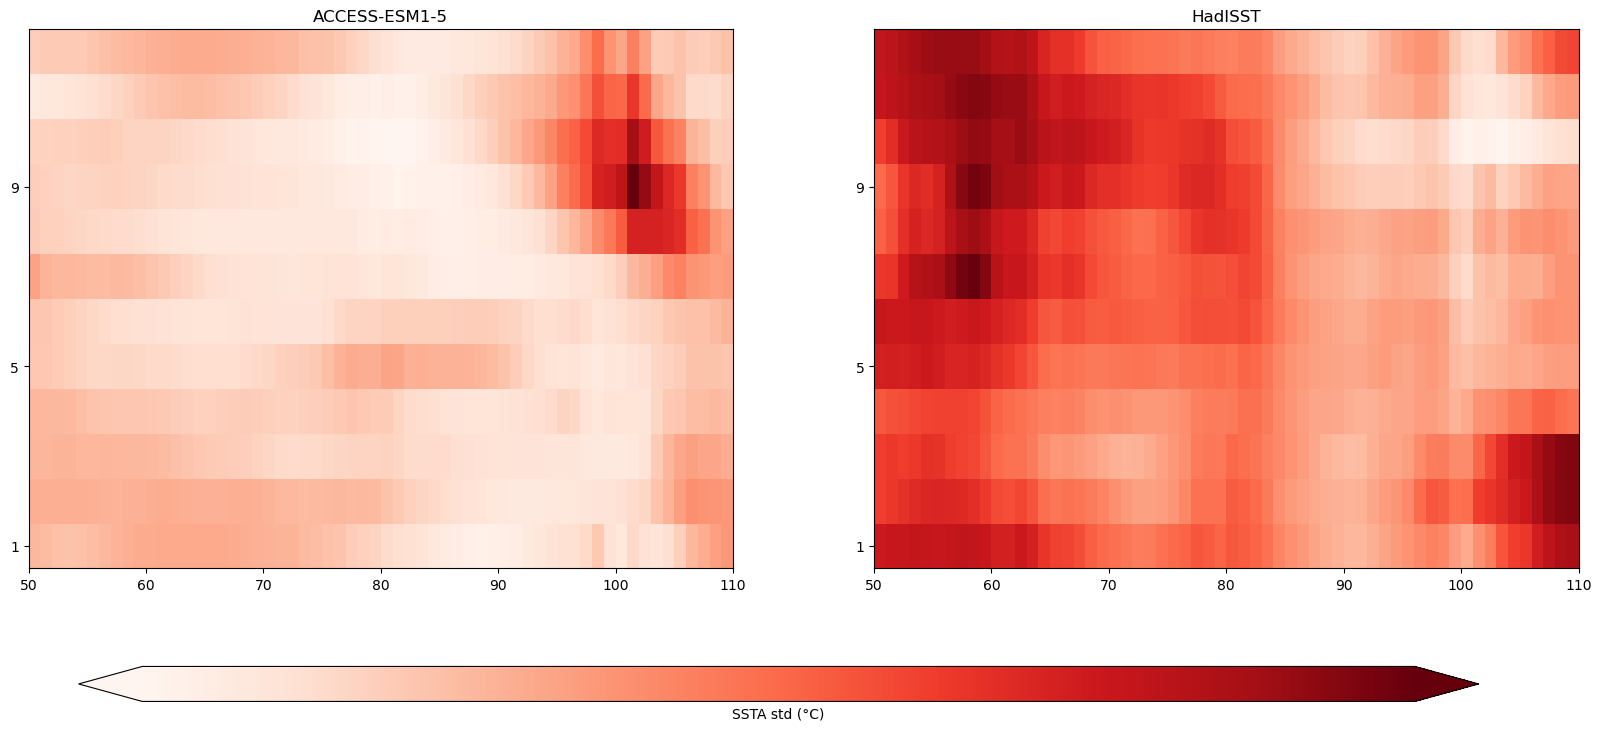

In [21]:
import iris.plot as iplt
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 7))
i =121


for label, cube in data_prep_3.items():
    
    ax1 = plt.subplot(i)
    c1 = iplt.pcolormesh(cube, cmap='Reds')
    ax1.set_yticks([1,5,9])
    ax1.set_title(label)

    i+=1


# Add a single colorbar at the bottom
cax = plt.axes([0.15,-0.08,0.7,0.05])
cbar = fig.colorbar(c1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(0,2,0.5))
cbar.set_label('SSTA std (°C)')